In [1]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  


# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt



# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
 


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [2]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
print(tf.test.is_built_with_cuda())
print(tf.test.is_built_with_gpu_support())
print(tf.test.gpu_device_name())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
True
True
/device:GPU:0


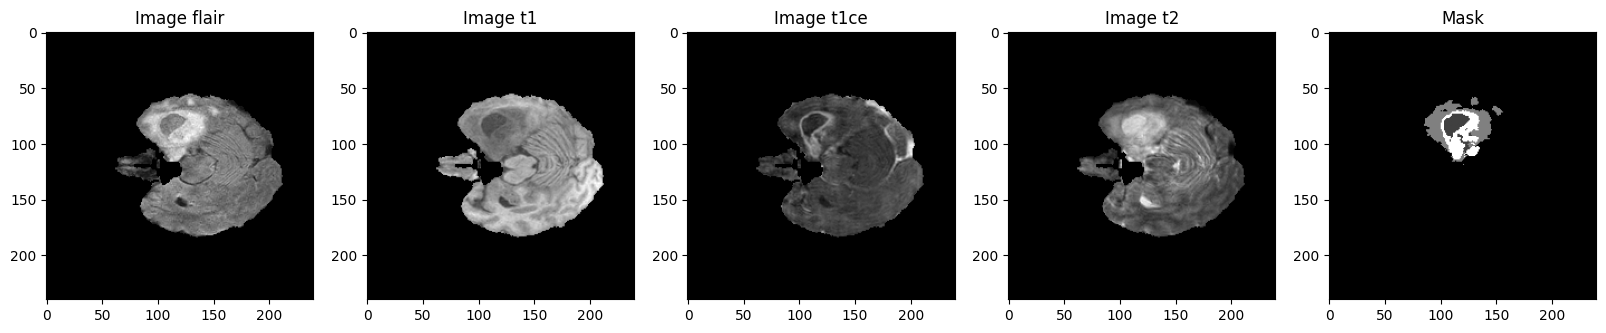

In [3]:
import nibabel as nib
import matplotlib.pyplot as plt

TRAIN_DATASET_PATH = '/kaggle/input/brain-tumor-segmentation-in-mri-brats-2015/MICCAI_BraTS2020_TrainingData/'


modalities = ['flair', 't1', 't1ce', 't2']
image_data = {}


for modality in modalities:
    image_data[modality] = nib.load(f'{TRAIN_DATASET_PATH}BraTS20_Training_001/BraTS20_Training_001_{modality}.nii').get_fdata()


test_mask = nib.load(f'{TRAIN_DATASET_PATH}BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata()


#print("Shape of Images ",image_data['flair'].shape)


fig, axes = plt.subplots(1, 5, figsize=(20, 10))
slice_w = 70


titles = ['Image flair', 'Image t1', 'Image t1ce', 'Image t2', 'Mask']


for ax, (modality, title) in zip(axes, zip(modalities, titles)):
    ax.imshow(image_data[modality][:, :, image_data[modality].shape[0] // 2 - slice_w], cmap='gray')
    ax.set_title(title)


axes[4].imshow(test_mask[:, :, test_mask.shape[0] // 2 - slice_w], cmap='gray')

axes[4].set_title('Mask')

plt.show()

In [4]:

unique_labels = np.unique(test_mask)
print("Unique labels in the mask:", unique_labels)

Unique labels in the mask: [0. 1. 2. 4.]


In [5]:
print(np.unique(test_mask))  #0, 1, 2, 4 (Need to reencode to 0, 1, 2, 3)
test_mask[test_mask==4] = 3  #Reassign mask values 4 to 3
print(np.unique(test_mask))

[0. 1. 2. 4.]
[0. 1. 2. 3.]


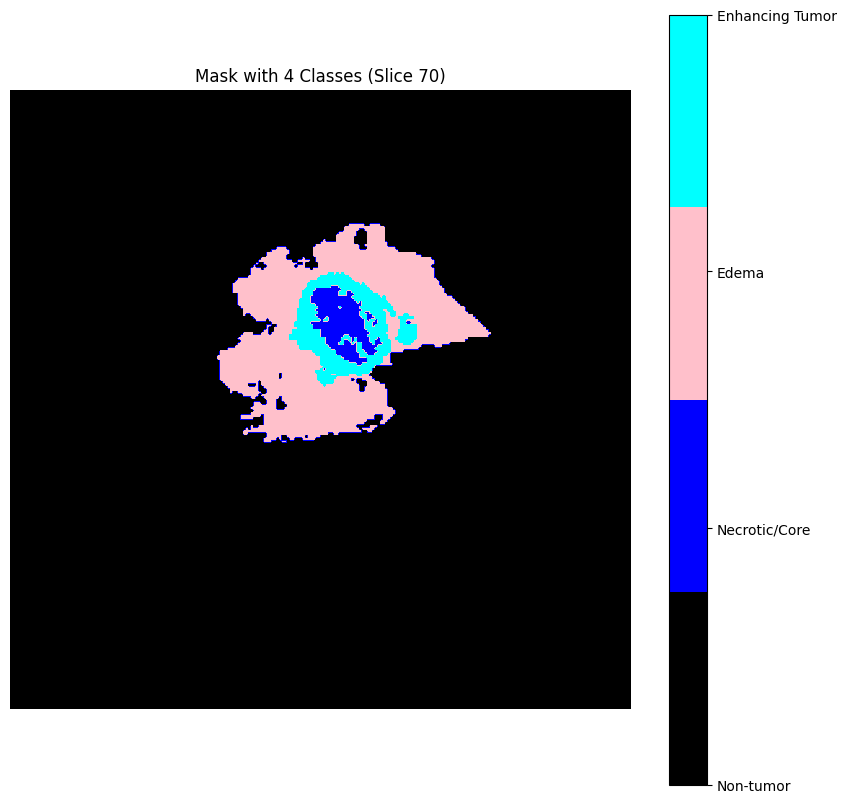

In [6]:

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

slice_index = 70

# Extract the mask slice
mask_slice = test_mask[:, :, slice_index]


class_colors = ['black', 'blue', 'pink', 'cyan'] 
cmap = ListedColormap(class_colors)


class_labels = ['Non-tumor', 'Necrotic/Core', 'Edema', 'Enhancing Tumor']


plt.figure(figsize=(10, 10))
plt.imshow(mask_slice, cmap=cmap)


colorbar = plt.colorbar(ticks=[0, 1, 2, 3])  # Set ticks to match class values
colorbar.set_ticklabels(class_labels)  # Set tick labels to class names

plt.title(f'Mask with 4 Classes (Slice {slice_index})')
plt.axis('off')
plt.show()

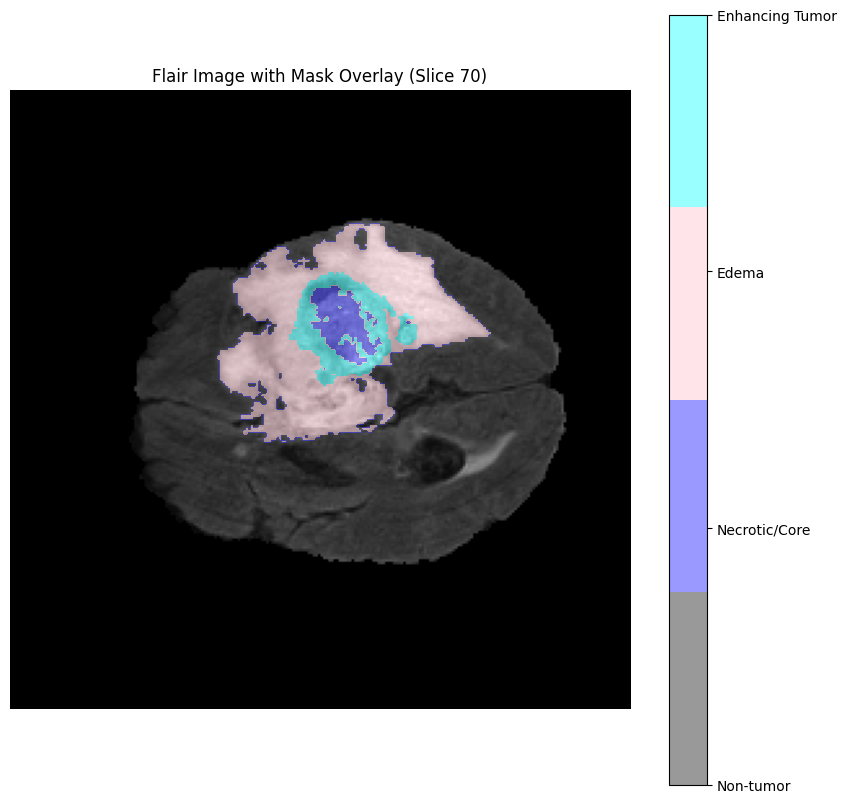

In [7]:


 

# Extract the flair image and mask slices
flair_slice = image_data['flair'][:, :, slice_index]
mask_slice = test_mask[:, :, slice_index]

 
class_colors = ['black', 'blue', 'pink', 'cyan'] 
cmap = ListedColormap(class_colors)

 
plt.figure(figsize=(10, 10))

# Display the flair image
plt.imshow(flair_slice, cmap='gray')

# Overlay the mask with transparency
plt.imshow(mask_slice, cmap=cmap, alpha=0.4)

# Add a colorbar with class labels
colorbar = plt.colorbar(ticks=[0, 1, 2, 3])  # Set ticks to match class values
colorbar.set_ticklabels(['Non-tumor', 'Necrotic/Core', 'Edema', 'Enhancing Tumor'])  # Set tick labels to class names

plt.title(f'Flair Image with Mask Overlay (Slice {slice_index})')
plt.axis('off')
plt.show()

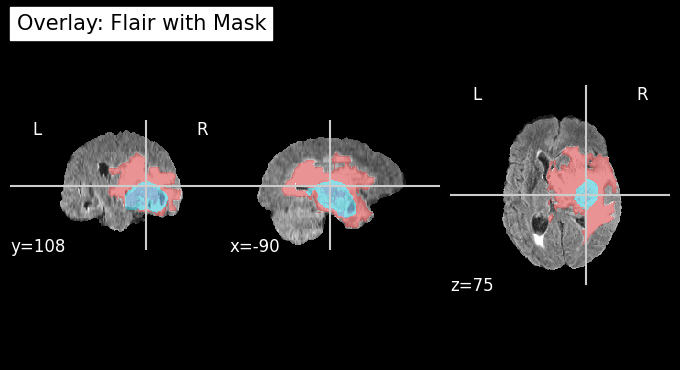

In [8]:
from nilearn import plotting, image
import nibabel as nib

flair_niimg = nib.load(f"{TRAIN_DATASET_PATH}BraTS20_Training_001/BraTS20_Training_001_flair.nii")
mask_niimg = nib.load(f"{TRAIN_DATASET_PATH}BraTS20_Training_001/BraTS20_Training_001_seg.nii")

 
display = plotting.plot_anat(
    flair_niimg,
    title="Overlay: Flair with Mask",
    display_mode="ortho",  # Displays all three planes (axial, sagittal, coronal)
    dim=-1  
)


display.add_overlay(mask_niimg, cmap="tab10", alpha=0.5)


plotting.show()

In [9]:



# Stack all modalities along the third axis to create a multi-channel image
combined_modalities = np.stack([image_data['flair'], image_data['t1ce'], image_data['t2']], axis=-1)

# Print shape to verify
print("Shape of combined modalities:", combined_modalities.shape)

Shape of combined modalities: (240, 240, 155, 3)


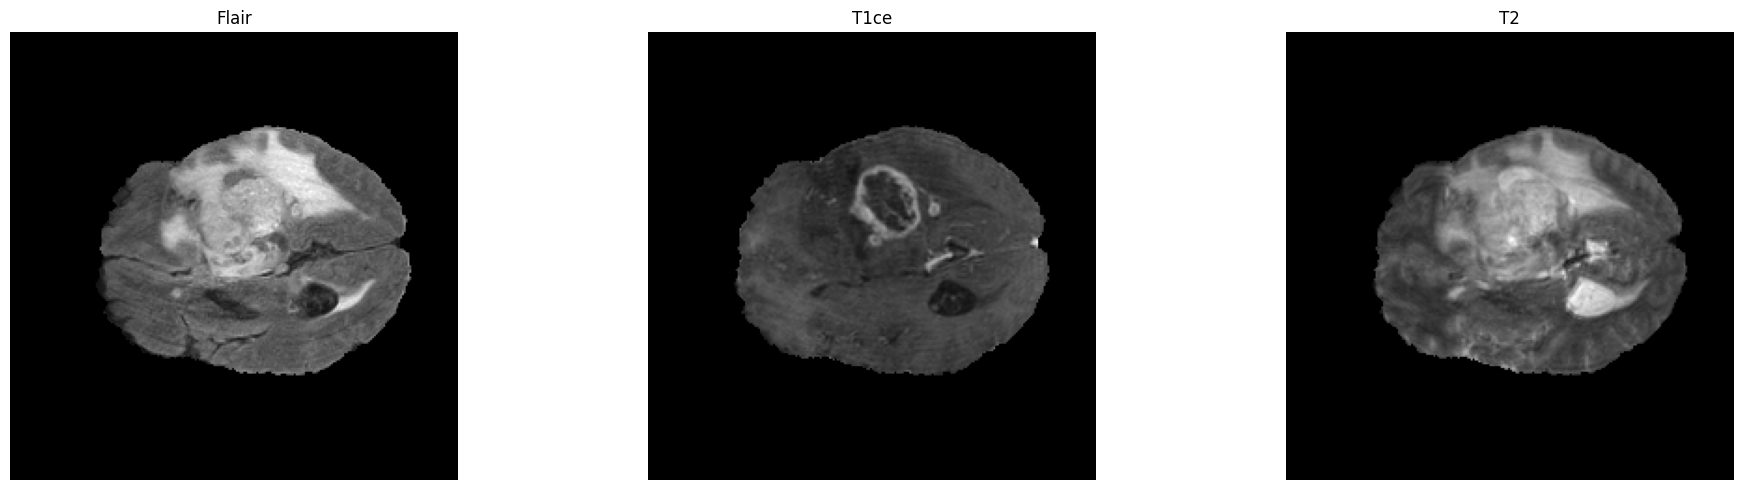

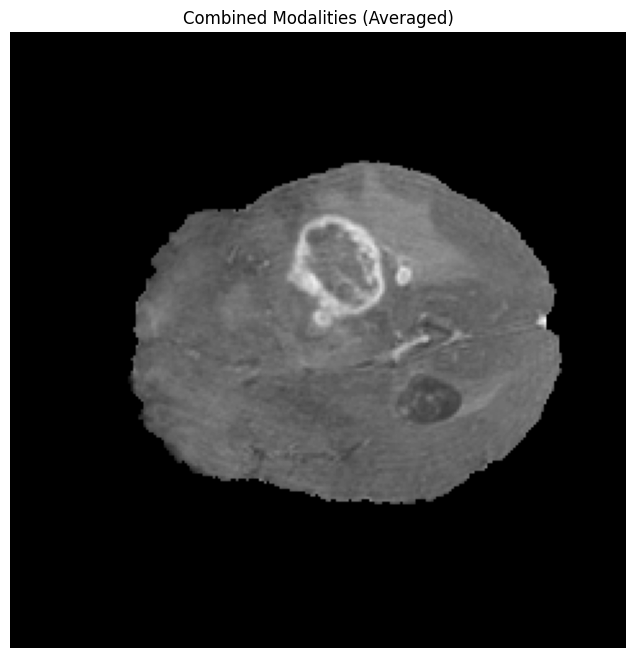

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Assume combined_modalities has shape (240, 240, 155, 3)
modalities = ['Flair', 'T1ce', 'T2']
slice_index = 70

# Plot each modality as a separate panel
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for i, (modality, ax) in enumerate(zip(modalities, axes)):
    # Access the specific slice for each modality
    modality_slice = combined_modalities[:, :, slice_index, i]
    ax.imshow(modality_slice, cmap='gray')
    ax.set_title(modality)
    ax.axis('off')

plt.tight_layout()
plt.show()

# Average all modalities across the 4th axis (channels)
combined_grayscale = np.mean(combined_modalities, axis=-1)

# Display the combined grayscale slice
plt.figure(figsize=(8, 8))
plt.imshow(combined_grayscale[:, :, slice_index], cmap='gray')
plt.title("Combined Modalities (Averaged)")
plt.axis('off')
plt.show()

In [11]:

for modality in ['flair', 't1ce', 't2']:
    print(f"Shape of {modality} image slice: {image_data[modality].shape}")

print(f"Shape of Combined Modalitiess {combined_modalities.shape}")
print(f"Shape of mask_slice {test_mask.shape}")

Shape of flair image slice: (240, 240, 155)
Shape of t1ce image slice: (240, 240, 155)
Shape of t2 image slice: (240, 240, 155)
Shape of Combined Modalitiess (240, 240, 155, 3)
Shape of mask_slice (240, 240, 155)


In [12]:

def crop_borders(image, mask, threshold=0):
 
    # Use the middle slice as a reference for cropping
    slice_index = image.shape[2] // 2
    ref_image = np.mean(image[:, :, slice_index, :], axis=-1)  # Averaging across channels for reference

    # Find non-zero pixels (above the threshold) in the reference slice
    rows = np.any(ref_image > threshold, axis=1)
    cols = np.any(ref_image > threshold, axis=0)
    
    # Find bounding box
    row_start, row_end = np.where(rows)[0][[0, -1]]
    col_start, col_end = np.where(cols)[0][[0, -1]]
    
    # Crop the image and mask using the computed boundaries
    cropped_image = image[row_start:row_end + 1, col_start:col_end + 1, :, :]
    cropped_mask = mask[row_start:row_end + 1, col_start:col_end + 1, :]
    
    return cropped_image, cropped_mask


In [13]:
cropped_combined,cropped_mask=crop_borders(combined_modalities,test_mask)

In [14]:
from skimage.transform import resize
import numpy as np

# Define the target size
target_size = (128, 128)

# Resize each modality
resized_slices = np.zeros((target_size[0], target_size[1], cropped_combined.shape[2], cropped_combined.shape[3]))

for i in range(cropped_combined.shape[3]):  # Iterate over modalities
    for j in range(cropped_combined.shape[2]):  # Iterate over slices (depth dimension)
        resized_slices[:, :, j, i] = resize(
            cropped_combined[:, :, j, i],
            target_size,
            anti_aliasing=True
        )

# Resize the mask (use nearest neighbor interpolation for class labels)
resized_mask = np.zeros((target_size[0], target_size[1], cropped_mask.shape[2]))

for j in range(cropped_mask.shape[2]):  # Iterate over slices (depth dimension)
    resized_mask[:, :, j] = resize(
        cropped_mask[:, :, j],
        target_size,
        order=0,  # Nearest neighbor interpolation
        preserve_range=True,
        anti_aliasing=False
    )

# Check the resized shapes
print("Shapes after resizing:")
print(f"Resized combined modalities shape: {resized_slices.shape}")
print(f"Resized mask shape: {resized_mask.shape}")

Shapes after resizing:
Resized combined modalities shape: (128, 128, 155, 3)
Resized mask shape: (128, 128, 155)


In [15]:
target_size = (128, 128)
original_depth = 155  # Assuming the original depth is 155 slices
reduced_depth = original_depth - 120 




def preprocess_data(image_data, mask_data, target_size=(128, 128), original_depth=155, reduced_depth=35):
    num_modalities = image_data.shape[3]
    num_classes = 4

    # Remove 20 slices from the beginning and 20 from the end
    image_data = image_data[..., 60:original_depth-60, :]
    mask_data = mask_data[..., 60:original_depth-60]

    # Initialize resized modalities array
    combined_modalities = np.zeros((*target_size, reduced_depth, num_modalities), dtype=np.float32)

    # Resize each slice of each modality
    for i in range(num_modalities):
        for z in range(reduced_depth):  # Process each slice
            combined_modalities[..., z, i] = resize(
                image_data[..., z, i], target_size, mode='reflect', anti_aliasing=True
            )

    # Resize and one-hot encode the mask
    resized_mask = np.zeros((*target_size, reduced_depth), dtype=np.uint8)
    for z in range(reduced_depth):  # Resize each slice of the mask
        resized_mask[..., z] = resize(
            mask_data[..., z], target_size, order=0, preserve_range=True, anti_aliasing=False
        ).astype(np.uint8)

    one_hot_mask = np.zeros((*resized_mask.shape, num_classes), dtype=np.uint8)
    for i, label in enumerate(range(num_classes)):  # Labels in the mask: 0, 1, 2, 3
        one_hot_mask[resized_mask == label, i] = 1

    return combined_modalities, one_hot_mask

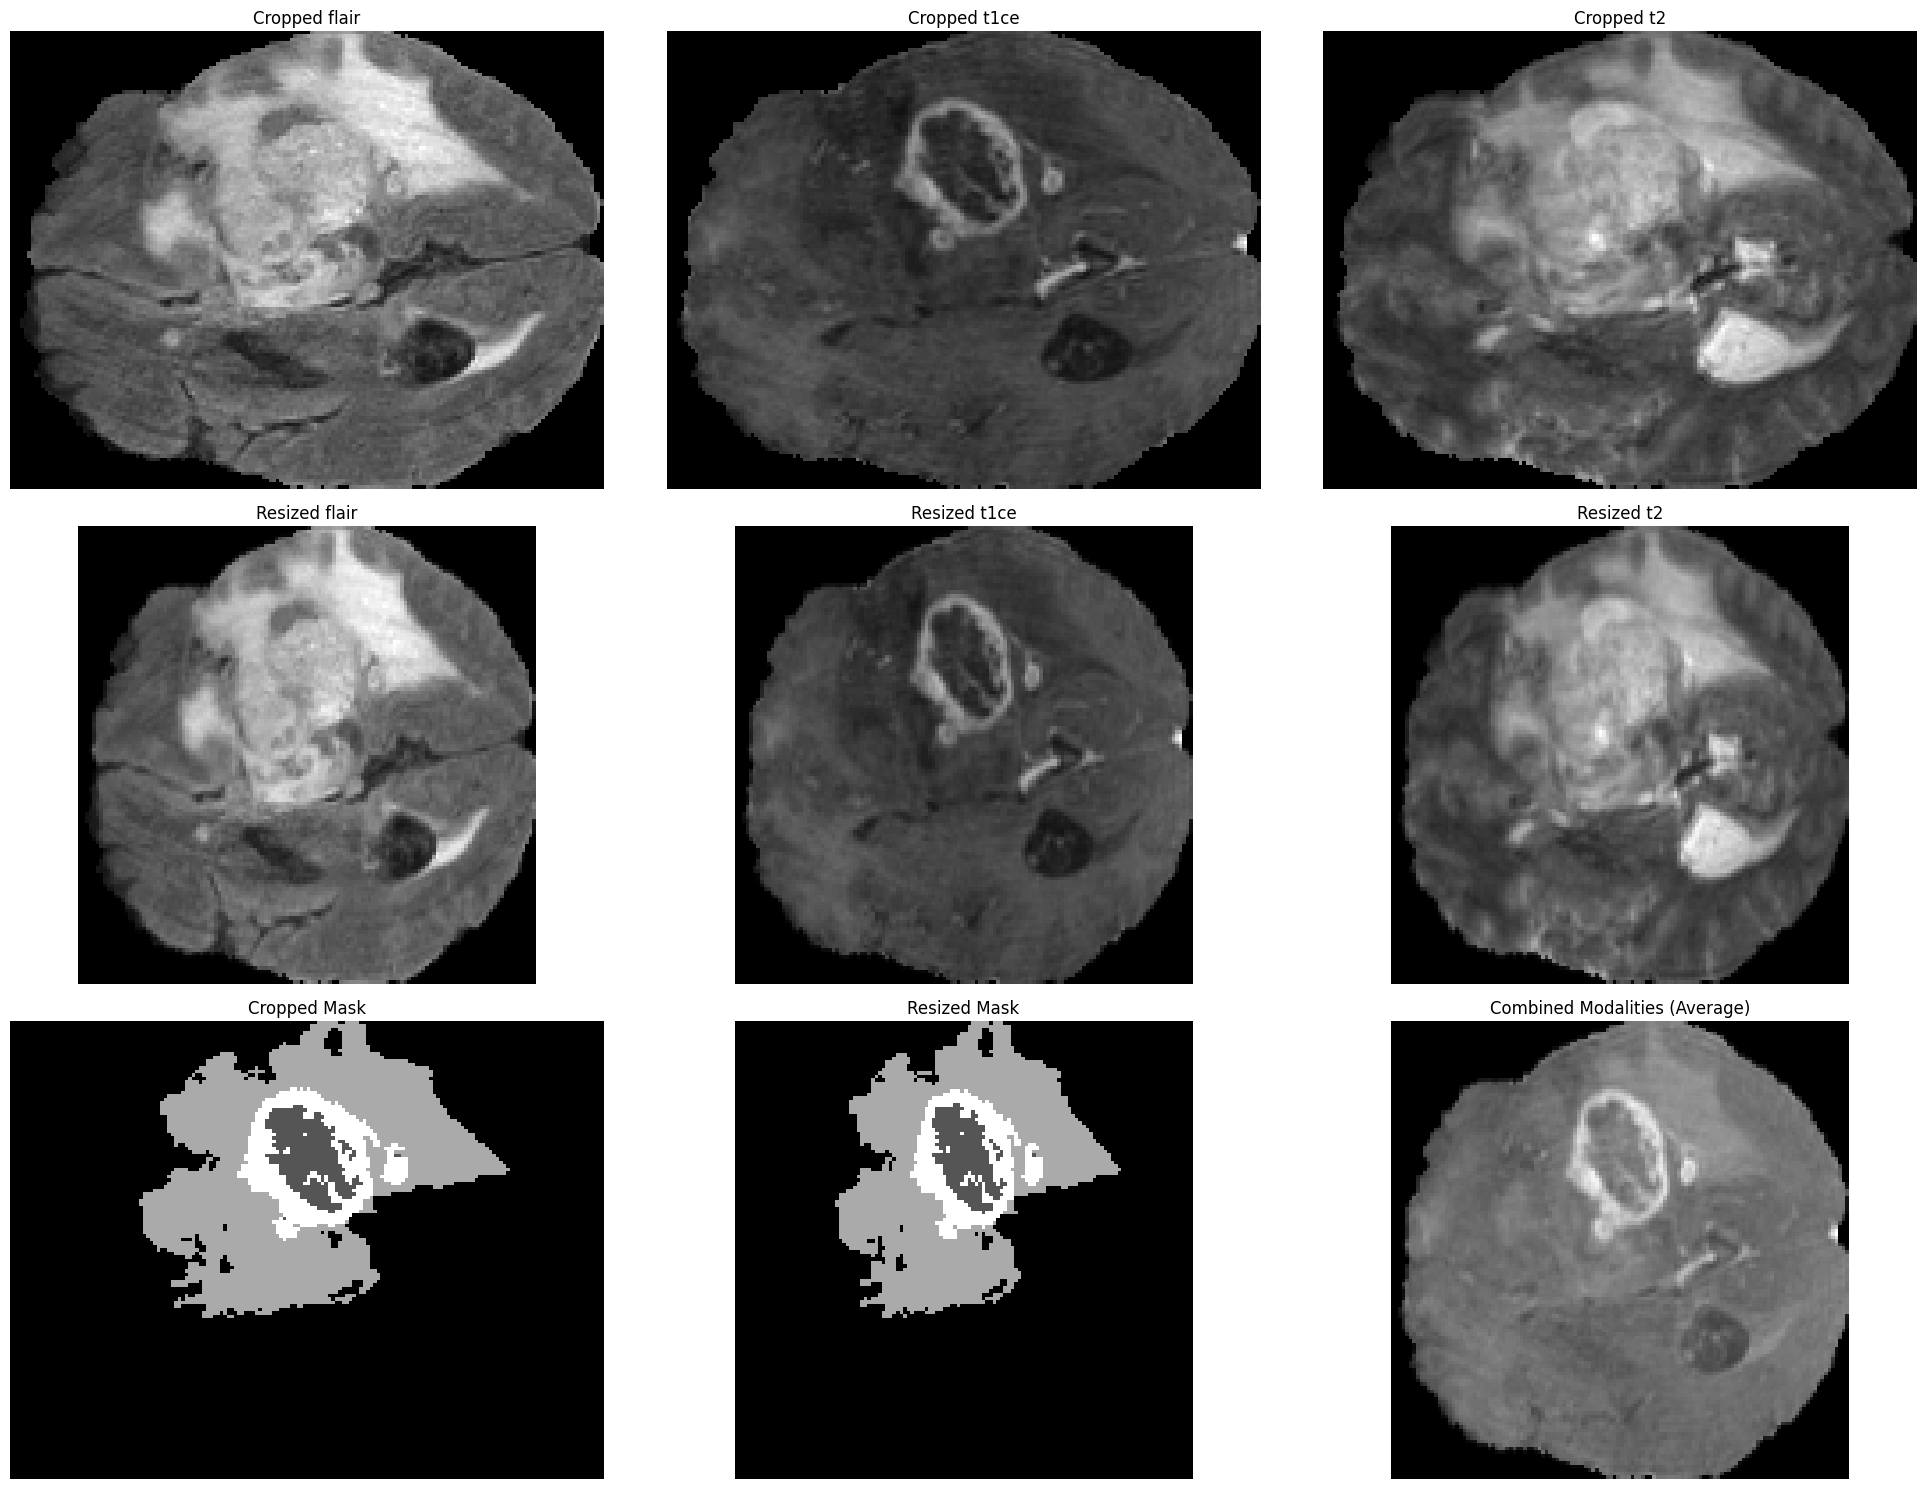

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Choose a slice index to visualize
slice_index = 70  # or any index within the range of your mask and combined image

# Plot cropped and resized slices along with the mask
fig, axes = plt.subplots(3, 3, figsize=(20, 15))

modalities = ['flair', 't1ce', 't2']
modality_indices = [0, 1, 2]  # Indices for flair, t1ce, and t2 modalities

# Plot cropped images for each modality
for i, modality_idx in enumerate(modality_indices):
    axes[0, i].imshow(cropped_combined[:, :, slice_index, modality_idx], cmap='gray')
    axes[0, i].set_title(f"Cropped {modalities[i]}")
    axes[0, i].axis('off')

# Plot resized images for each modality
for i, modality_idx in enumerate(modality_indices):
    axes[1, i].imshow(resized_slices[:, :, slice_index, modality_idx], cmap='gray')
    axes[1, i].set_title(f"Resized {modalities[i]}")
    axes[1, i].axis('off')

# Plot cropped mask (select a slice if the mask is 3D, otherwise show the whole image)
axes[2, 0].imshow(cropped_mask[:, :, slice_index], cmap='gray')  # Select a slice if mask is 3D
axes[2, 0].set_title("Cropped Mask")
axes[2, 0].axis('off')

# Plot resized mask (select a slice if the mask is 3D, otherwise show the whole image)
axes[2, 1].imshow(resized_mask[:, :, slice_index], cmap='gray')  # Select a slice if mask is 3D
axes[2, 1].set_title("Resized Mask")
axes[2, 1].axis('off')

# Plot the combined averaged image (slice_index) from resized modalities
# We average the modalities (flair, t1ce, t2) for the selected slice
combined_avg = np.mean(resized_slices[:, :, slice_index, :3], axis=-1)  # Average across flair, t1ce, and t2
axes[2, 2].imshow(combined_avg, cmap='gray')  # Display the combined averaged image
axes[2, 2].set_title("Combined Modalities (Average)")
axes[2, 2].axis('off')

# Hide extra axes in the last row
for ax in axes[2, 3:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [17]:
# Assuming `resized_slices` and `resized_mask` are ready from earlier preprocessing:
combined_modalities, one_hot_mask = preprocess_data(resized_slices, resized_mask)

print("Combined modalities shape:", combined_modalities.shape)  # Should be (H, W, D, modalities)
print("One-hot encoded mask shape:", one_hot_mask.shape)        # Should be (H, W, D, 4)

Combined modalities shape: (128, 128, 35, 3)
One-hot encoded mask shape: (128, 128, 35, 4)


Found 368 patient IDs.
Train set size: 294
Validation set size: 74


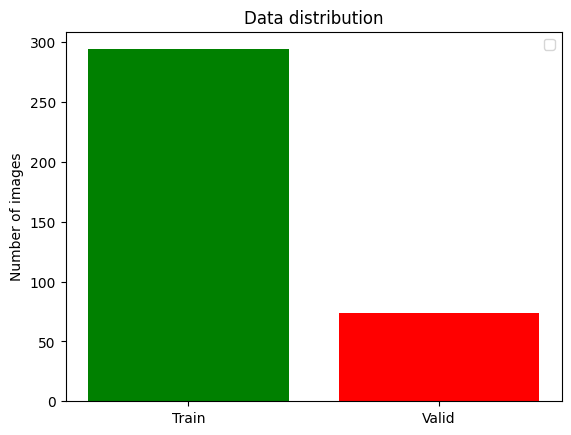

In [18]:
from sklearn.model_selection import train_test_split

# Get all patient directories, excluding BraTS20_Training_355
patient_ids = [
    d for d in os.listdir(TRAIN_DATASET_PATH) 
    if os.path.isdir(os.path.join(TRAIN_DATASET_PATH, d)) and d != "BraTS20_Training_355"
]

# Print the patient_ids list

print(f"Found {len(patient_ids)} patient IDs.")

# Split patient IDs into train, validation, and test
train_ids, val_ids = train_test_split(patient_ids, test_size=0.2, random_state=42)
#train_ids, val_ids = train_test_split(train_ids, test_size=0.2, random_state=42)

# Initialize data generators




print(f"Train set size: {len(train_ids)}")
#print(f"Test set size: {len(test_ids)}")
print(f"Validation set size: {len(val_ids)}")
# show number of data for each dir 
def showDataLayout():
    plt.bar(["Train","Valid"],
    [len(train_ids), len(val_ids)], align='center',color=[ 'green','red'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')

    plt.show()
    
showDataLayout()

In [19]:
import os
import nibabel as nib
import numpy as np
from skimage.transform import resize
from tqdm import tqdm

# Directories to save processed data
train_save_dir = "/kaggle/working/train_data"
val_save_dir = "/kaggle/working/val_data"
dataset_path=TRAIN_DATASET_PATH
# Make directories
os.makedirs(os.path.join(train_save_dir, "images"), exist_ok=True)
os.makedirs(os.path.join(train_save_dir, "masks"), exist_ok=True)
os.makedirs(os.path.join(val_save_dir, "images"), exist_ok=True)
os.makedirs(os.path.join(val_save_dir, "masks"), exist_ok=True)

# List of patient IDs (excluding 355 and ignoring unwanted files)
patient_ids = [p for p in os.listdir(dataset_path) if p.startswith("BraTS20") and p != "BraTS20_Training_355"]

# Split into train and val
split_idx = int(0.8 * len(patient_ids))
train_patients = patient_ids[:split_idx]
val_patients = patient_ids[split_idx:]

def load_and_preprocess_patient(patient_id, save_dir, target_size=(128, 128), num_modalities=3, num_classes=4):
    """Load, preprocess, and save slices for a single patient."""
    patient_path = os.path.join(dataset_path, patient_id)
    modalities = ['flair', 't1ce', 't2'][:num_modalities]
    
    # Load and normalize modalities
    image_data = []
    for modality in modalities:
        modality_path = os.path.join(patient_path, f"{patient_id}_{modality}.nii")
        img = nib.load(modality_path).get_fdata()
        img = (img - np.min(img)) / (np.max(img) - np.min(img))  # Normalize
        image_data.append(img)
    
    # Stack modalities together: (H, W, S, C)
    combined_data = np.stack(image_data, axis=-1)
    
    # Load mask and remap labels
    mask_path = os.path.join(patient_path, f"{patient_id}_seg.nii")
    mask_data = nib.load(mask_path).get_fdata()
    mask_data[mask_data == 4] = 3  # Remap label 4 to 3
    
    # Save slices excluding first and last 60 slices
    num_slices = mask_data.shape[2]
    valid_slices = range(60, num_slices - 60)
    
    for z_index in tqdm(valid_slices, desc=f"Processing {patient_id}"):
        # Extract slices
        slice_img = combined_data[:, :, z_index, :]
        slice_mask = mask_data[:, :, z_index]
        
        # Resize images and masks
        resized_img = resize(slice_img, (target_size[0], target_size[1]), preserve_range=True, mode='reflect', anti_aliasing=True)
        resized_mask = resize(slice_mask, (target_size[0], target_size[1]), preserve_range=True, mode='reflect', anti_aliasing=True)
        
        # One-hot encode mask
        resized_mask = np.eye(num_classes)[resized_mask.astype(np.int32)]
        
        # Save to disk
        np.save(os.path.join(save_dir, "images", f"{patient_id}_slice{z_index}.npy"), resized_img)
        np.save(os.path.join(save_dir, "masks", f"{patient_id}_slice{z_index}.npy"), resized_mask)

# Process and save train data
for patient in train_patients:
    load_and_preprocess_patient(patient, train_save_dir)

# Process and save validation data
for patient in val_patients:
    load_and_preprocess_patient(patient, val_save_dir)

print("Preprocessing and saving completed successfully!")


Processing BraTS20_Training_297: 100%|██████████| 35/35 [00:00<00:00, 108.73it/s]

Preprocessing and saving completed successfully!


In [20]:


# Define the paths to the saved train and validation data
train_images_path = "/kaggle/working/train_data/images"
train_masks_path = "/kaggle/working/train_data/masks"
val_images_path = "/kaggle/working/val_data/images"
val_masks_path = "/kaggle/working/val_data/masks"

# Count the total number of images in train and val sets
num_train_images = len(os.listdir(train_images_path))
num_val_images = len(os.listdir(val_images_path))

print(f"Number of training images: {num_train_images}")
print(f"Number of validation images: {num_val_images}")


Number of training images: 10290
Number of validation images: 2590


Visualizing training samples:


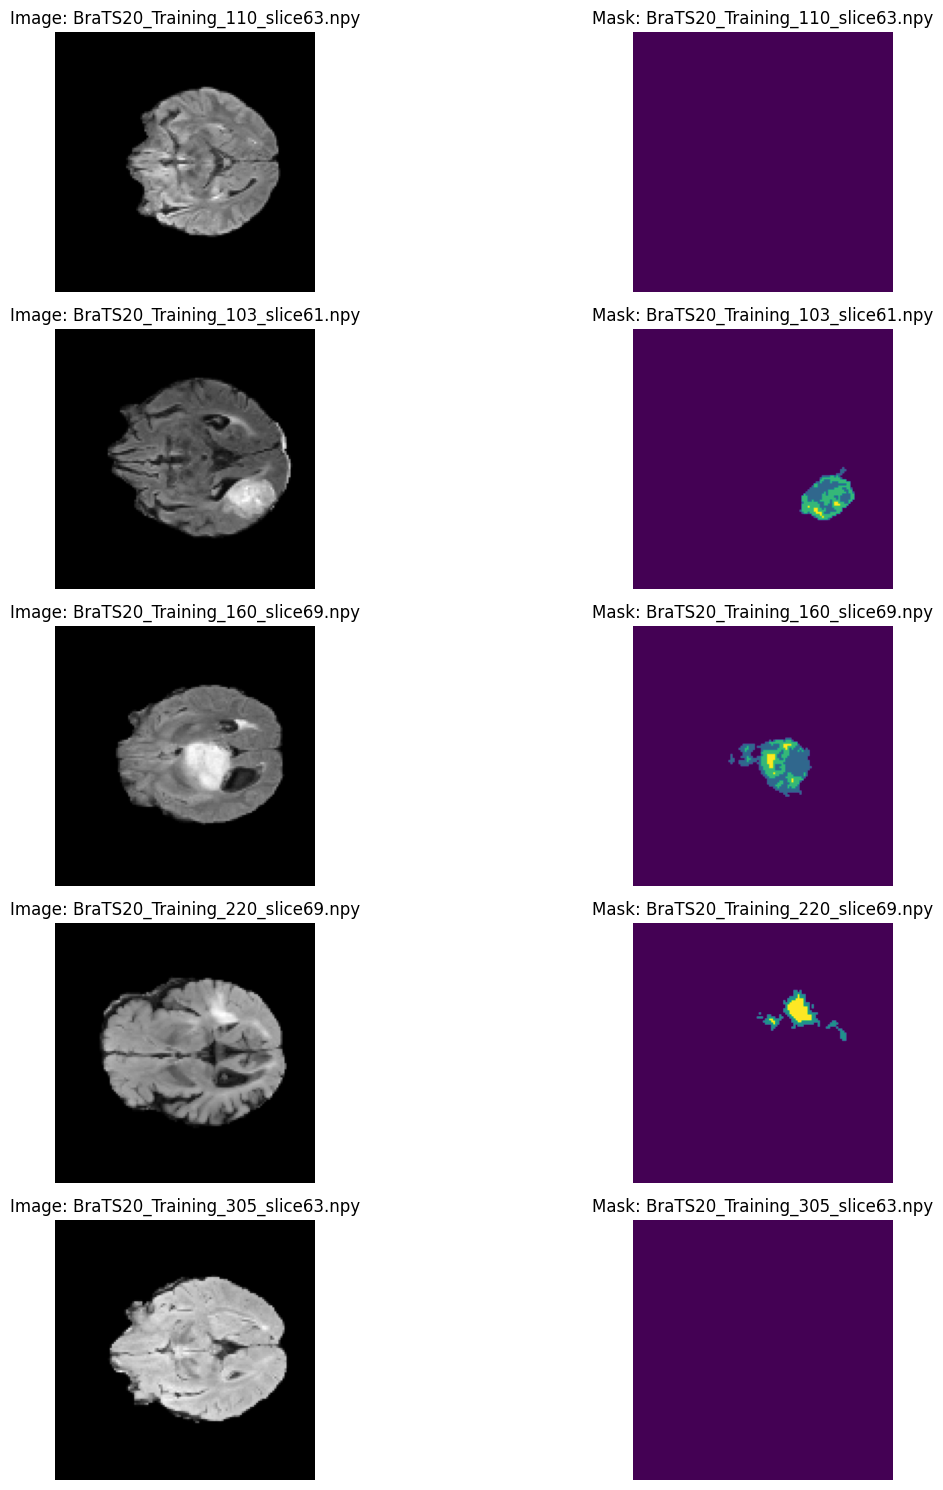

Visualizing validation samples:


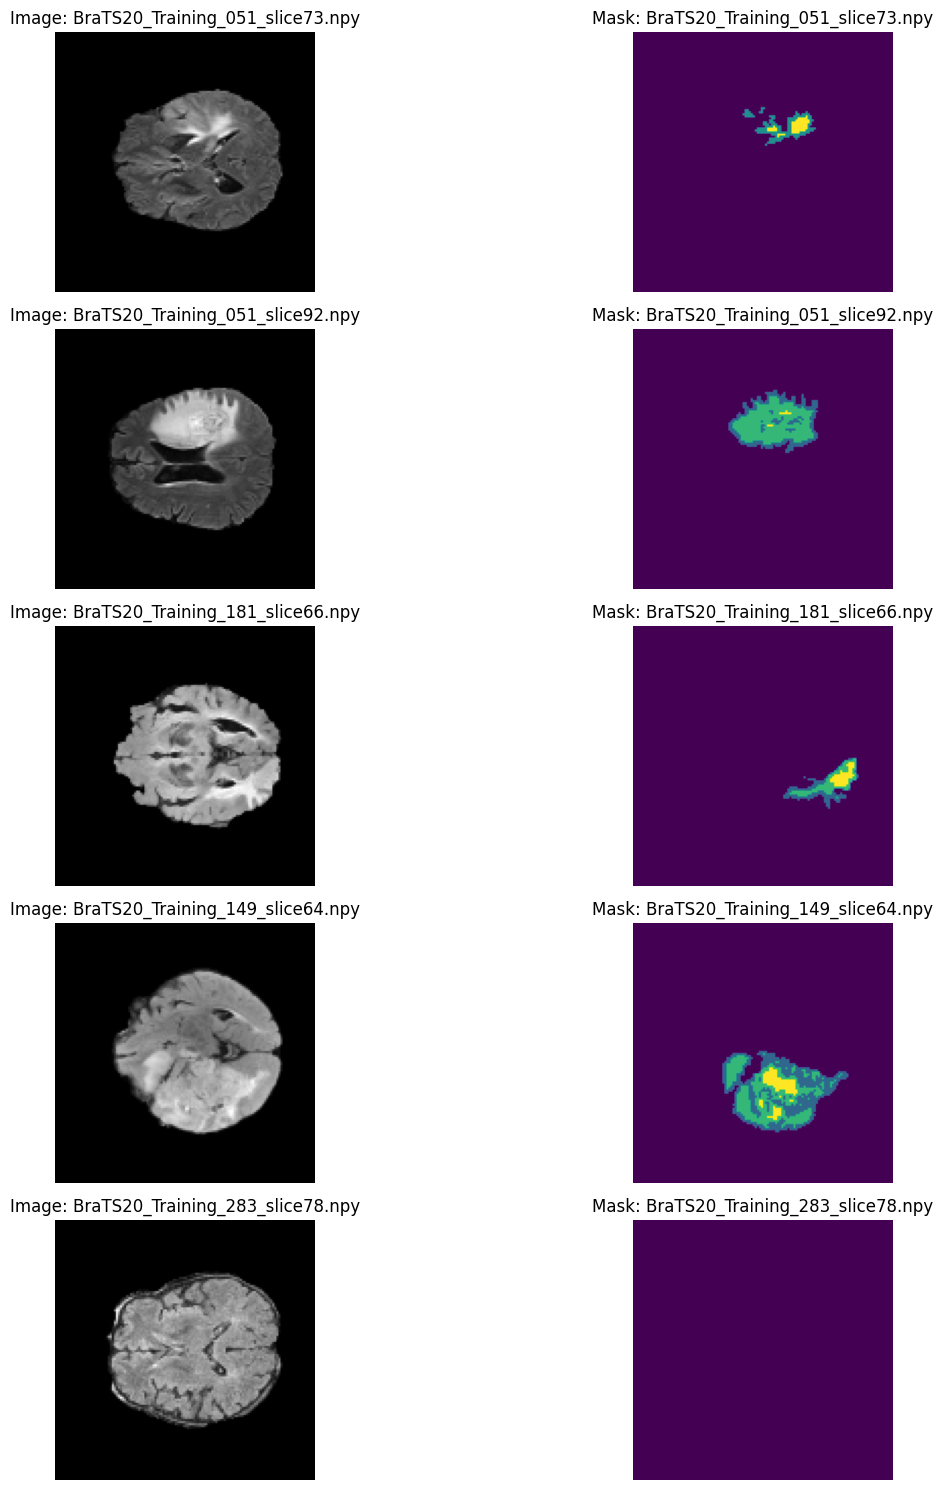

In [21]:
import random
def visualize_samples(images_path, masks_path, num_samples=5, num_classes=4):
    image_files = sorted(os.listdir(images_path))
    mask_files = sorted(os.listdir(masks_path))

    random_indices = random.sample(range(len(image_files)), num_samples)

    plt.figure(figsize=(15, num_samples * 3))
    for i, idx in enumerate(random_indices):
        # Load image and mask
        img = np.load(os.path.join(images_path, image_files[idx]))
        mask = np.load(os.path.join(masks_path, mask_files[idx]))

        # Convert mask back to single-channel for visualization
        mask_single_channel = np.argmax(mask, axis=-1)

        # Plot image and mask
        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(img[:, :, 0], cmap='gray')  # Display the first modality
        plt.title(f"Image: {image_files[idx]}")
        plt.axis("off")

        plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(mask_single_channel, cmap='viridis')
        plt.title(f"Mask: {mask_files[idx]}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Visualize random training samples
print("Visualizing training samples:")
visualize_samples(train_images_path, train_masks_path, num_samples=5)

# Visualize random validation samples
print("Visualizing validation samples:")
visualize_samples(val_images_path, val_masks_path, num_samples=5)

In [22]:
from tensorflow.keras.utils import Sequence

class BrainTumorDataGenerator(Sequence):
    def __init__(self, images_path, masks_path, batch_size=16, shuffle=True):
        self.images_path = images_path
        self.masks_path = masks_path
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.image_files = sorted(os.listdir(images_path))
        self.mask_files = sorted(os.listdir(masks_path))
        self.on_epoch_end()

    def __len__(self):
        """Number of batches per epoch."""
        return int(np.floor(len(self.image_files) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data."""
        batch_image_files = self.image_files[index * self.batch_size:(index + 1) * self.batch_size]
        batch_mask_files = self.mask_files[index * self.batch_size:(index + 1) * self.batch_size]

        images, masks = self.__load_batch(batch_image_files, batch_mask_files)
        return np.array(images), np.array(masks)

    def __load_batch(self, batch_image_files, batch_mask_files):
        """Load a batch of images and masks."""
        images = []
        masks = []

        for img_file, mask_file in zip(batch_image_files, batch_mask_files):
            img = np.load(os.path.join(self.images_path, img_file))
            mask = np.load(os.path.join(self.masks_path, mask_file))
            images.append(img)
            masks.append(mask)

        return images, masks

    def on_epoch_end(self):
        """Shuffle data at the end of each epoch."""
        if self.shuffle:
            combined = list(zip(self.image_files, self.mask_files))
            random.shuffle(combined)
            self.image_files, self.mask_files = zip(*combined)

# Initialize data generators
batch_size = 16
train_generator = BrainTumorDataGenerator(train_images_path, train_masks_path, batch_size=batch_size)
val_generator = BrainTumorDataGenerator(val_images_path, val_masks_path, batch_size=batch_size, shuffle=False)


In [23]:
import tensorflow.keras.backend as K

def weighted_dice_loss(y_true, y_pred, class_weights):
    """Weighted Dice Loss for imbalanced classes."""
    smooth = 1e-6
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')

    intersection = K.sum(y_true * y_pred, axis=[1, 2])
    union = K.sum(y_true + y_pred, axis=[1, 2])

    dice = (2.0 * intersection + smooth) / (union + smooth)
    weighted_dice = -K.sum(class_weights * dice, axis=-1)
    return K.mean(weighted_dice)

# Example class weights (adjust based on your dataset):
class_weights = np.array([0.45, 0.25, 0.20, 0.20])  # Equal weights for all


In [24]:
import tensorflow as tf
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth=1.0):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = K.sum(y_true * y_pred, axis=(1, 2, 3))
    return K.mean((2. * intersection + smooth) / 
                  (K.sum(y_true, axis=(1, 2, 3)) + K.sum(y_pred, axis=(1, 2, 3)) + smooth))
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    y_true = K.cast(y_true, y_pred.dtype)  # Cast y_true to the same dtype as y_pred
    y_true_necrotic = y_true[..., 1]  # Class 1: NECROTIC/CORE
    y_pred_necrotic = y_pred[..., 1]
    intersection = K.sum(K.abs(y_true_necrotic * y_pred_necrotic))
    return (2. * intersection) / (K.sum(K.square(y_true_necrotic)) + K.sum(K.square(y_pred_necrotic)) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    y_true = K.cast(y_true, y_pred.dtype)  # Cast y_true to the same dtype as y_pred
    y_true_edema = y_true[..., 2]  # Class 2: EDEMA
    y_pred_edema = y_pred[..., 2]
    intersection = K.sum(K.abs(y_true_edema * y_pred_edema))
    return (2. * intersection) / (K.sum(K.square(y_true_edema)) + K.sum(K.square(y_pred_edema)) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    y_true = K.cast(y_true, y_pred.dtype)  # Cast y_true to the same dtype as y_pred
    y_true_enhancing = y_true[..., 3]  # Class 3: ENHANCING
    y_pred_enhancing = y_pred[..., 3]
    intersection = K.sum(K.abs(y_true_enhancing * y_pred_enhancing))
    return (2. * intersection) / (K.sum(K.square(y_true_enhancing)) + K.sum(K.square(y_pred_enhancing)) + epsilon)

def precision(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def sensitivity(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())


In [25]:
# Import Necessary Libraries
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, Conv2D, Dropout, BatchNormalization, UpSampling2D, concatenate
from tensorflow.keras.models import Model

# Define the Simplified U-Net Model Architecture
def build_unet(input_shape=(128, 128, 3), num_classes=4):
    inputs = Input(input_shape)
    
    # Encoder: Using EfficientNetB0 as a Backbone
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=inputs)
    
    # Extract Encoder Outputs for Skip Connections
    skip1 = base_model.get_layer('block2a_expand_activation').output  # 64x64
    skip2 = base_model.get_layer('block3a_expand_activation').output  # 32x32
    skip3 = base_model.get_layer('block4a_expand_activation').output  # 16x16
    skip4 = base_model.get_layer('block6a_expand_activation').output  # 8x8
    
    # Bottleneck
    x = base_model.output  # 4x4
    
    # Decoder: Manually Implemented Layers (No Loops)
    # 1st Decoder Block
    x = UpSampling2D()(x)  # Upsample 4x4 -> 8x8
    x = concatenate([x, skip4])  # Add Skip Connection
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    # 2nd Decoder Block
    x = UpSampling2D()(x)  # Upsample 8x8 -> 16x16
    x = concatenate([x, skip3])  # Add Skip Connection
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    # 3rd Decoder Block
    x = UpSampling2D()(x)  # Upsample 16x16 -> 32x32
    x = concatenate([x, skip2])  # Add Skip Connection
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    # 4th Decoder Block
    x = UpSampling2D()(x)  # Upsample 32x32 -> 64x64
    x = concatenate([x, skip1])  # Add Skip Connection
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    # Final Upsampling to Match Input Resolution
    x = UpSampling2D()(x)  # Upsample 64x64 -> 128x128
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    # Output Layer
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(x)  # Final Segmentation Map
    
    # Define the Model
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Create the U-Net Model
input_shape = (128, 128, 3)  # Define your input shape here
num_classes = 4  # Define the number of classes for your segmentation task
model = build_unet(input_shape, num_classes)




16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [26]:
strategy = tf.distribute.MirroredStrategy()

In [27]:
with strategy.scope():
    model = build_unet(input_shape=(128, 128, 3), num_classes=4)  # Your U-Net model
    model.compile(
        optimizer='adam',
        loss=lambda y_true, y_pred: weighted_dice_loss(y_true, y_pred, class_weights),
        metrics=['accuracy',dice_coef]
    )

In [28]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)


In [29]:
print(f"Number of devices: {strategy.num_replicas_in_sync}")



Number of devices: 2


In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Define the callback to save the best model
checkpoint = ModelCheckpoint(
    "/kaggle/working/best_model.keras", 
    monitor="val_loss", 
    save_best_only=True, 
    mode="min", 
    verbose=1
)

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss", 
    factor=0.5, 
    patience=3, 
    verbose=1, 
    min_lr=1e-6
)

#model.compile(optimizer='adam', loss=lambda y_true, y_pred: weighted_dice_loss(y_true, y_pred, class_weights), metrics=['accuracy'])
print(f"Number of devices: {strategy.num_replicas_in_sync}")


history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=30,
        callbacks=[checkpoint, lr_scheduler]
        
    )



Number of devices: 2
Epoch 1/30


2024-12-17 03:27:48.956579: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/cond/else/_1706/cond/StatefulPartitionedCall/functional_3_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.7331 - dice_coef: 0.6924 - loss: -0.4787
Epoch 1: val_loss improved from inf to -0.50653, saving model to /kaggle/working/best_model.keras


/opt/conda/lib/python3.10/site-packages/keras/src/saving/serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:         loss=lambda y_true, y_pred: weighted_dice_loss(y_true, y_pred, class_weights),

  return {key: serialize_keras_object(value) for key, value in obj.items()}


643/643 ━━━━━━━━━━━━━━━━━━━━ 265s 204ms/step - accuracy: 0.7332 - dice_coef: 0.6926 - loss: -0.4788 - val_accuracy: 0.9566 - val_dice_coef: 0.9543 - val_loss: -0.5065 - learning_rate: 0.0010
Epoch 2/30
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.9792 - dice_coef: 0.9781 - loss: -0.6719
Epoch 2: val_loss improved from -0.50653 to -0.67230, saving model to /kaggle/working/best_model.keras
643/643 ━━━━━━━━━━━━━━━━━━━━ 119s 185ms/step - accuracy: 0.9792 - dice_coef: 0.9781 - loss: -0.6720 - val_accuracy: 0.9783 - val_dice_coef: 0.9782 - val_loss: -0.6723 - learning_rate: 0.0010
Epoch 3/30
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.9838 - dice_coef: 0.9837 - loss: -0.6951
Epoch 3: val_loss improved from -0.67230 to -0.68390, saving model to /kaggle/working/best_model.keras
643/643 ━━━━━━━━━━━━━━━━━━━━ 119s 185ms/step - accuracy: 0.9838 - dice_coef: 0.9837 - loss: -0.6950 - val_accuracy: 0.9759 - val_dice_coef: 0.9758 - val_loss: -0.6839 - learning_rate: 0.0010
Epo

In [31]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 128, 128,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 128, 128,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 128, 128,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 129, 129,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 64, 64,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 64, 64,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 64, 64,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 64, 64,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 64, 64,    │        512 │ block1a_se_excit

 Total params: 27,898,809 (106.43 MB)

 Trainable params: 9,285,264 (35.42 MB)

 Non-trainable params: 43,015 (168.03 KB)

 Optimizer params: 18,570,530 (70.84 MB)

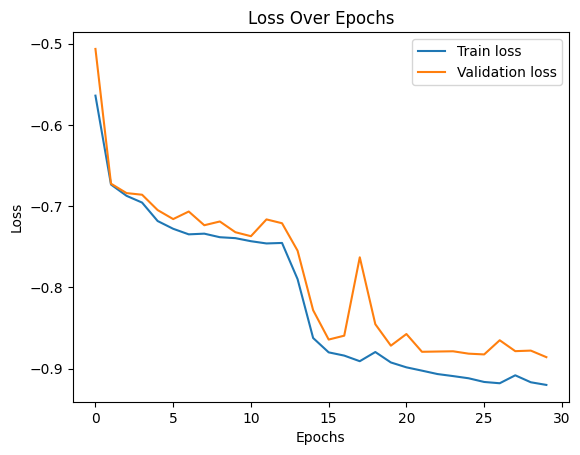

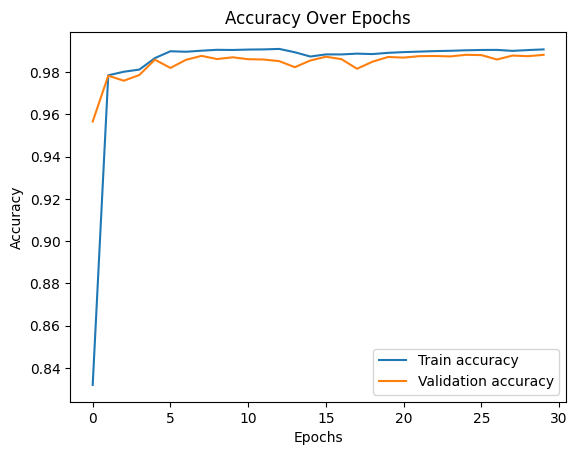

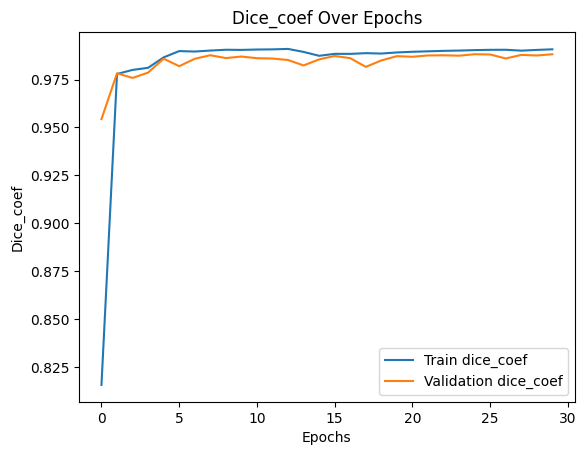

In [32]:
# Visualize training and validation metrics
def plot_training_history(history):
    metrics = ["loss", "accuracy",'dice_coef']
    for metric in metrics:
        plt.plot(history.history[metric], label=f"Train {metric}")
        plt.plot(history.history[f"val_{metric}"], label=f"Validation {metric}")
        plt.title(f"{metric.capitalize()} Over Epochs")
        plt.xlabel("Epochs")
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.show()

plot_training_history(history)


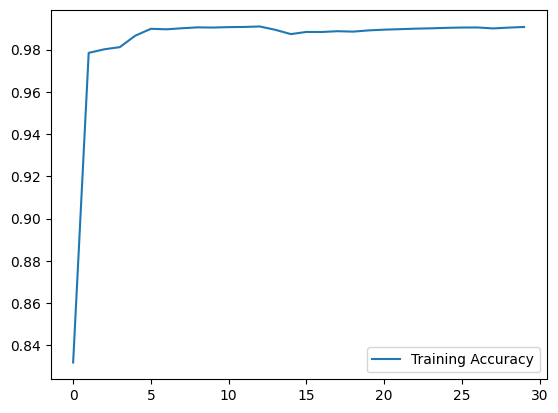

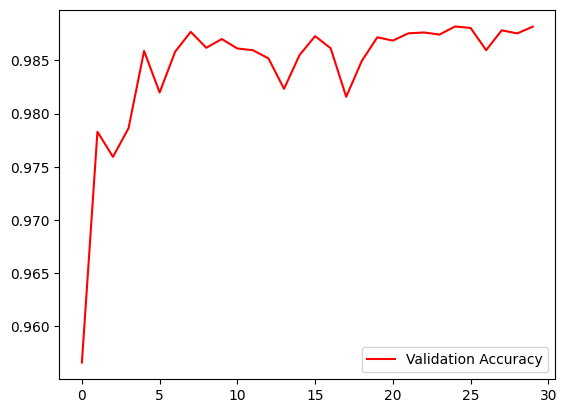

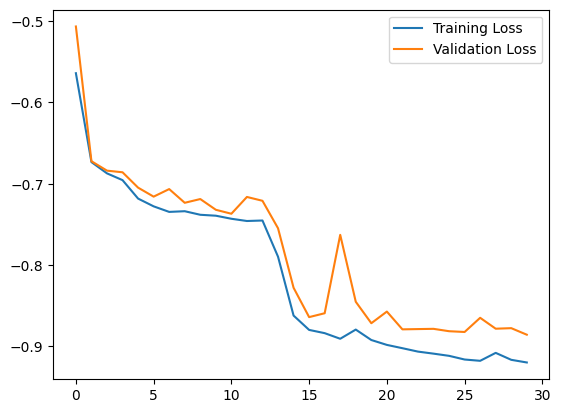

In [33]:
import matplotlib.pyplot as plt

# Assuming 'history' contains the training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.legend()
plt.show()
plt.plot(history.history['val_accuracy'], label='Validation Accuracy',color='r')
plt.legend()
plt.show()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

In [34]:
from tensorflow.keras.models import load_model



best_model_path = "/kaggle/working/best_model.keras"
best_model = load_model(best_model_path, safe_mode=False,
                         custom_objects={'weighted_dice_loss': weighted_dice_loss, 
                                         'dice_coef': dice_coef})

W0000 00:00:1734409697.221464      23 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Conv2D" attr { key: "T" value { type: DT_FLOAT } } attr { key: "data_format" value { s: "NCHW" } } attr { key: "dilations" value { list { i: 1 i: 1 i: 1 i: 1 } } } attr { key: "explicit_paddings" value { list { } } } attr { key: "padding" value { s: "VALID" } } attr { key: "strides" value { list { i: 1 i: 1 i: 2 i: 2 } } } attr { key: "use_cudnn_on_gpu" value { b: true } } inputs { dtype: DT_FLOAT shape { dim { } dim { size: 3 } dim { size: 129 } dim { size: 129 } } } inputs { dtype: DT_FLOAT shape { dim { size: 3 } dim { size: 3 } dim { size: 3 } dim { size: 32 } } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12030" } environment { key: "cudnn" value: "8906" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multip

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


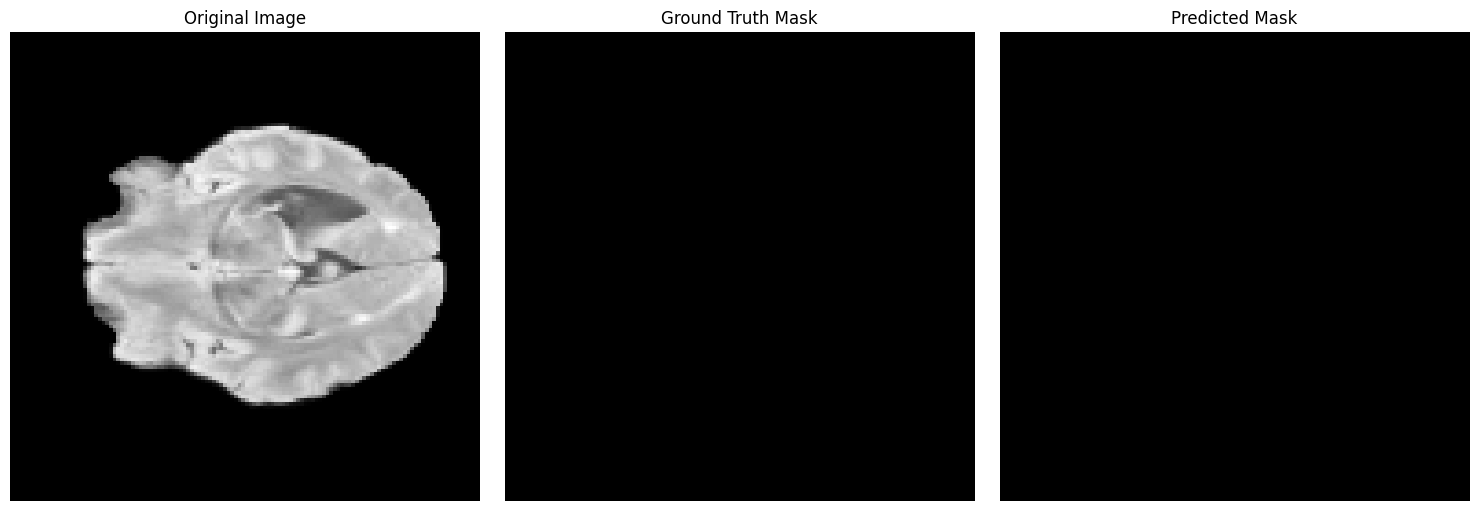

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


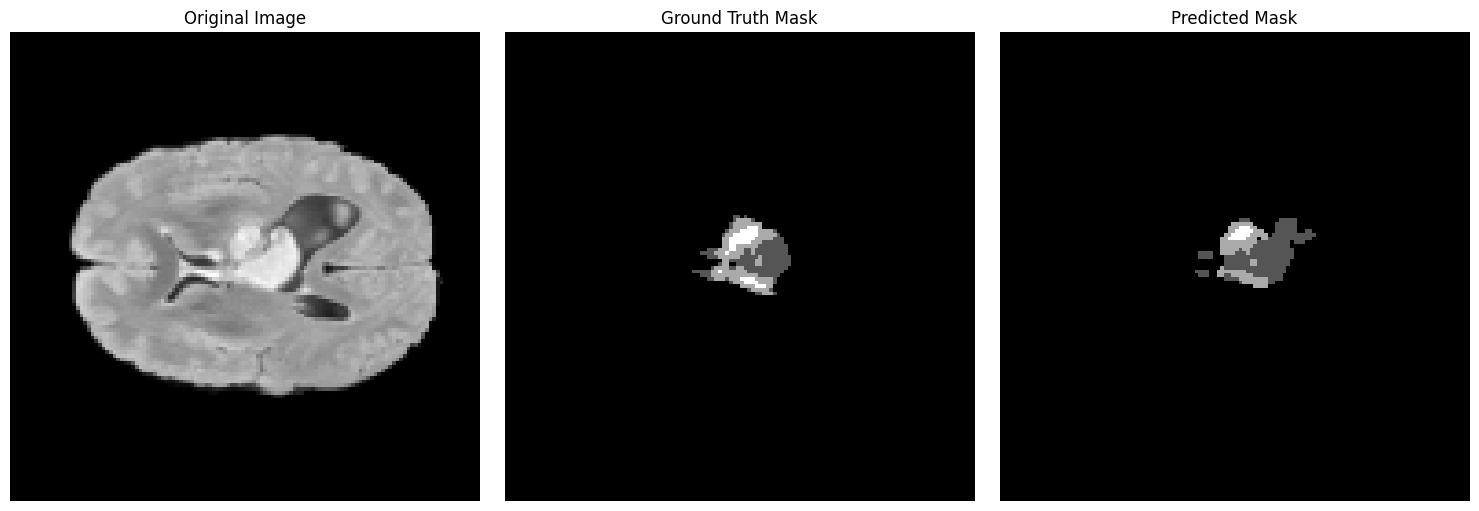

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


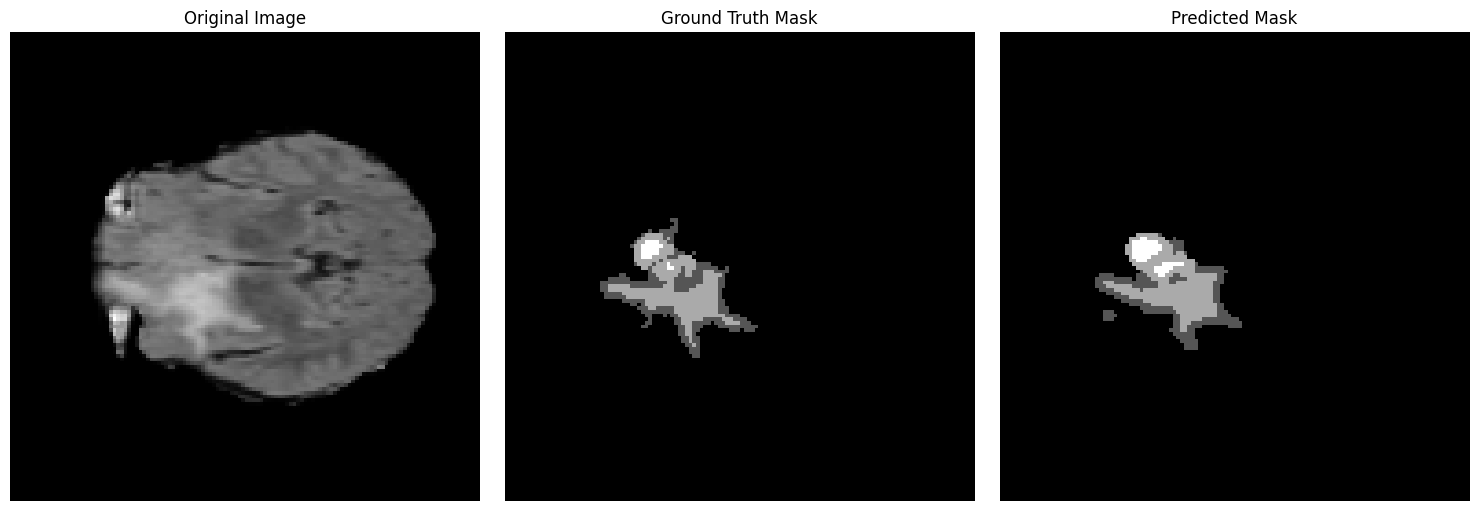

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


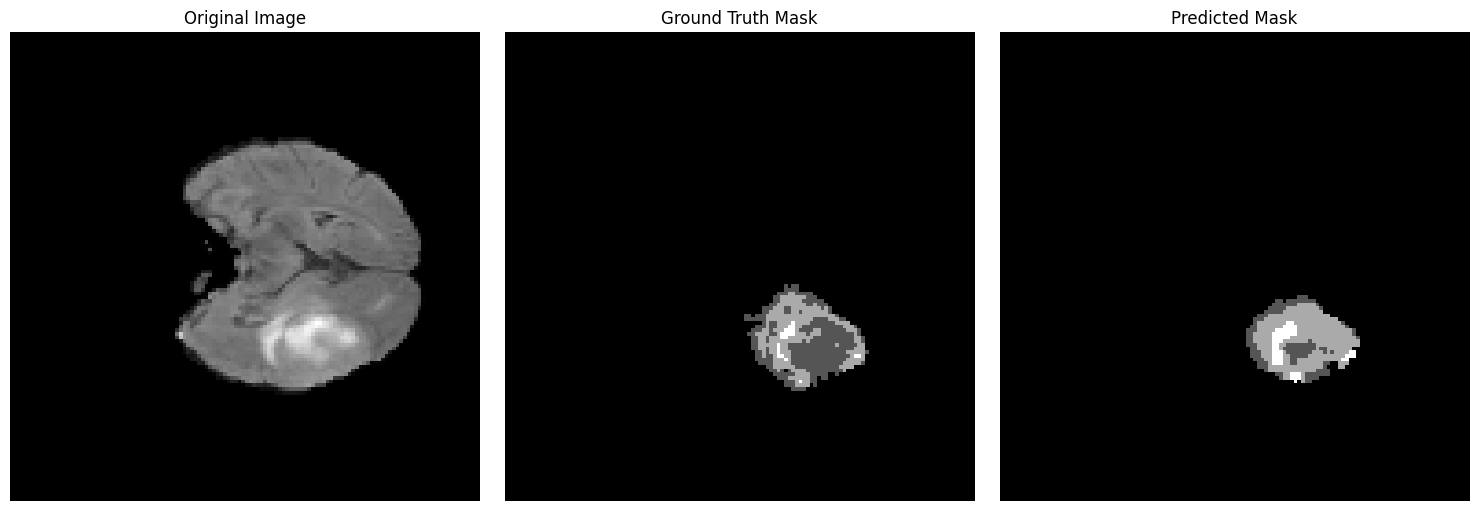

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


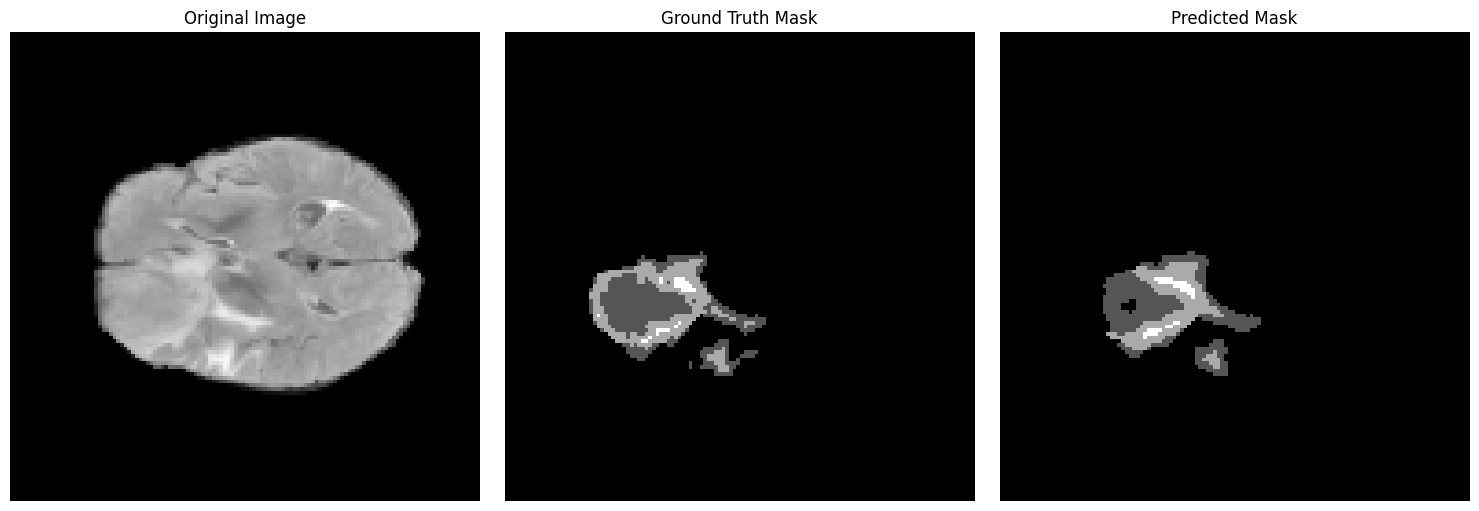

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

def visualize_prediction(model, images_path, masks_path, num_samples=1):
    """
    Visualize model predictions for brain tumor segmentation
    
    Parameters:
    - model: Trained Keras model
    - images_path: Path to saved image numpy files
    - masks_path: Path to saved mask numpy files
    - num_samples: Number of samples to visualize
    """
    # Get list of image and mask files
    image_files = sorted(os.listdir(images_path))
    mask_files = sorted(os.listdir(masks_path))
    
    # Randomly select samples
    random_indices = np.random.choice(len(image_files), num_samples, replace=False)
    
    for idx in random_indices:
        # Load image and ground truth mask
        img = np.load(os.path.join(images_path, image_files[idx]))
        true_mask = np.load(os.path.join(masks_path, mask_files[idx]))
        
        # Prepare image for prediction (add batch dimension)
        img_for_pred = np.expand_dims(img, axis=0)
        
        # Make prediction
        pred_mask = model.predict(img_for_pred)[0]
        
        # Create visualization
        plt.figure(figsize=(15, 5))
        
        # Original Image (first modality)
        plt.subplot(1, 3, 1)
        plt.imshow(img[:, :, 0], cmap='gray')
        plt.title('Original Image')
        plt.axis('off')
        
        # Ground Truth Mask
        plt.subplot(1, 3, 2)
        true_mask_single = np.argmax(true_mask, axis=-1)
        plt.imshow(true_mask_single, cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')
        
        # Predicted Mask
        plt.subplot(1, 3, 3)
        pred_mask_single = np.argmax(pred_mask, axis=-1)
        plt.imshow(pred_mask_single, cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()

# Example usage:
# Load the best saved model
best_model_path = "/kaggle/working/best_model.keras"
best_model = tf.keras.models.load_model(
    best_model_path,safe_mode=False, 
    custom_objects={
        'weighted_dice_loss': lambda y_true, y_pred: weighted_dice_loss(y_true, y_pred, class_weights),
        'dice_coef': dice_coef
    }
)

# Paths to validation images and masks
val_images_path = "/kaggle/working/val_data/images"
val_masks_path = "/kaggle/working/val_data/masks"

# Visualize predictions
visualize_prediction(model, val_images_path, val_masks_path, num_samples=5)